<a href="https://colab.research.google.com/github/junrenwang/PEcAn/blob/master/GEEAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#ref: https://developers.google.com/earth-engine/python_install-colab
#ref: https://gis.stackexchange.com/questions/313186/extracting-pixel-time-series-from-google-earth-engine?rq=1
#ref: https://stackoverflow.com/questions/46943061/how-to-iterate-over-and-download-each-image-in-an-image-collection-from-the-goog
#ref: https://developers.google.com/earth-engine/reducers_reduce_region

#run !pip install netCDF4 if you don't have netCDF4 package
import ee
import netCDF4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#import model output result I only use year 2004 
def readModelOutput(name):
  model_output_2004 = netCDF4.Dataset(name)
  LAI = model_output_2004.variables['LAI'][:]
  LAT = model_output_2004.variables['lat'][:].data[0]
  LON = model_output_2004.variables['lon'][:].data[0]
  TIME = model_output_2004.variables['time'][:]
  LAI_array = np.zeros(int(len(TIME)))
  for i in range(0,len(LAI_array)):
    LAI_array[i] = LAI[i,0,0]
  return LAT,LON,LAI_array# I am a little confused about the TIME which gives me random number but I assume that it shows the result for every 30 minutes based on the length of TIME

In [0]:
# define a function to calculate NDVI
def extractNDVI(source,lon,lat,start,end,band_name):
  L8 = ee.ImageCollection(source)
  point = ee.Geometry.Point([lon,lat])
  filtered_images = L8.filterBounds(point).filterDate(start,end)
  def calculateNDVI(image):
    NDVI = image.normalizedDifference(['B5', 'B4']).rename(band_name)
    return(NDVI)
  NDVIcollection = filtered_images.map(calculateNDVI)
  NDVIlist = NDVIcollection.toList(NDVIcollection.size())
  NDVIlist_size = NDVIlist.size().getInfo()
  store = []
  date_store = []
  # Loop over all images and extract pixel value
  for i in range(NDVIlist_size):
    im = ee.Image(NDVIlist.get(i))
    # Obtain date from timestamp in metadata
    date = im.get("system:index").getInfo()[-8:]
    date_store.append(date)
    # Extract pixel value
    projection = im.projection().getInfo()['crs']
    data = im.select(band_name)\
        .reduceRegion(ee.Reducer.first(), point,\
            crs= projection,crsTransform=[30, 0, 397485, 0, -30, 4575615])\
        .get(band_name)
    store.append(data.getInfo())
    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])
  return df



In [4]:
#pipeline
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=4x7z50qXlOaA-z9ZjS69woN67MPsJNliim2SYTTxzGc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/yAFvsd_WQMLtxOiavVk28D454YPWLARu8WYcrRJFNMu_UU3E--SfbPU

Successfully saved authorization token.


In [0]:
source = 'LANDSAT/LC08/C01/T1_TOA'
start_time = '2014-01-01'
end_time = '2014-12-31'
band_name = 'NDVI'
lat,lon,LAI = readModelOutput('2004.nc')
NDVI_df = extractNDVI(source,lon,lat,start_time,end_time,band_name)

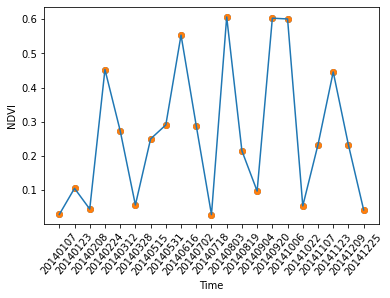

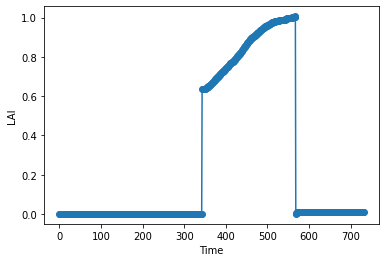

In [8]:
#plot 
plt.scatter(NDVI_df.index,NDVI_df['NDVI'])
plt.plot(NDVI_df.index,NDVI_df['NDVI'])
plt.scatter(NDVI_df.index,NDVI_df['NDVI'])
plt.xticks(rotation =50)
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.show()
x = [x for x in range(len(LAI))]
plt.scatter(x,LAI)
plt.plot(x,LAI)
plt.xlabel("Time")
plt.ylabel("LAI")
plt.show()